# 注意力集中：Nadaraya-Watson 内核回归
:label:`sec_nadaraya-waston`

现在你知道了 :numref:`fig_qkv` 框架下关注机制的主要组成部分。概括一下，查询（名义提示）和键（非自豪提示）之间的交互导致了 * 注意力集中 *。注意力集中有选择性地聚合了值（感官输入）以产生产出。在本节中，我们将更详细地介绍注意力集中，以便让您从高层次了解注意力机制在实践中的运作方式。具体来说，1964 年提出的 Nadaraya-Watson 内核回归模型是一个简单而完整的示例，用于演示具有注意机制的机器学习。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

为了简单起见，让我们考虑以下回归问题：给定输入-产出对 $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ 的数据集，如何学习 $f$ 来预测任何新输入 $\hat{y} = f(x)$ 的输出 $\hat{y} = f(x)$？

在这里，我们根据以下非线性函数生成一个人工数据集，噪声术语 $\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中 $\epsilon$ 服从平均值和标准差 0.5 的正态分布。同时生成了 50 个培训示例和 50 个测试示例。为了以后更好地直观地显示注意力模式，训练输入将进行排序。


In [9]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train)*5 )  # Training inputs
x_train

tensor([0.0411, 0.0433, 0.2635, 0.4344, 0.4455, 0.5465, 0.8262, 0.9809, 1.2024,
        1.3795, 1.3998, 1.5295, 1.7452, 1.7482, 1.8940, 1.9340, 1.9600, 2.0091,
        2.0145, 2.0245, 2.1362, 2.1711, 2.3292, 2.6899, 2.7646, 2.8862, 2.9556,
        3.0044, 3.0823, 3.2866, 3.4197, 3.4314, 3.5380, 3.5398, 3.6091, 3.6468,
        3.6921, 3.7716, 3.7970, 3.7973, 4.0131, 4.0552, 4.0909, 4.0929, 4.1099,
        4.2016, 4.6196, 4.7642, 4.7845, 4.8453])

In [10]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

以下函数绘制所有训练示例（由圆表示）、不带噪声项的地面真实数据生成函数 `f`（标记为 “Truth”）和学习的预测函数（标记为 “Pred”）。


In [11]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均池

我们首先可能是世界上对这个回归问题的 “最愚蠢” 的估算器：使用平均汇集来计算所有训练输出的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
:eqlabel:`eq_avg-pooling`

这如下图所示。正如我们所看到的，这个估算器确实不那么聪明。


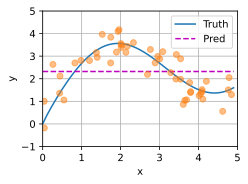

In [12]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数化注意力池

显然，平均池忽略了输入 $x_i$。Nadaraya :cite:`Nadaraya.1964` 和 Waston :cite:`Watson.1964` 提出了一个更好的想法，根据输入位置对输出 $y_i$ 进行权衡：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
:eqlabel:`eq_nadaraya-waston`

其中 $K$ 是 * 内核 *。:eqref:`eq_nadaraya-waston` 中的估计器被称为 *Nadaraya-Watson 内核回归 *。在这里我们不会深入研究内核的细节。回想一下 :numref:`fig_qkv` 中的关注机制框架。从注意力的角度来看，我们可以用更广泛的 * 注意力集合 * 的形式重写 :eqref:`eq_nadaraya-waston`：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
:eqlabel:`eq_attn-pooling`

其中 $x$ 是查询，$(x_i, y_i)$ 是键值对。比较 :eqref:`eq_attn-pooling` 和 :eqref:`eq_avg-pooling`，这里的注意力集中是 $y_i$ 的加权平均值。根据查询 $x$ 和 $\alpha$ 建模的密钥 $x_i$ 之间的交互作用，将 :eqref:`eq_attn-pooling` 中的 * 注意力权重 * $\alpha(x, x_i)$ 分配给相应的值 $y_i$。对于任何查询，它在所有键值对上的注意力权重都是有效的概率分布：它们是非负数的，总和为一。

要获得注意力集中的直觉，只需考虑一个 * 高斯内核 * 定义为

$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).
$$

将高斯内核插入 :eqref:`eq_attn-pooling` 和 :eqref:`eq_nadaraya-waston` 就会给出

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$
:eqlabel:`eq_nadaraya-waston-gaussian`

在 :eqref:`eq_nadaraya-waston-gaussian` 中，接近给定查询 $x$ 的密钥 $x_i$ 将得到
*通过分配给密钥的相应值 $y_i$ 的 * 更大的注意力重量 * 来进一步注意 *。

值得注意的是，Nadaraya-Watson 内核回归是一个非参数模型；因此，:eqref:`eq_nadaraya-waston-gaussian` 就是 * 非参数化注意力池 * 的示例。在下面，我们基于此非参数化关注模型绘制预测。预测的线是平稳的，并且比普通集中产生的线更接近地面真相。


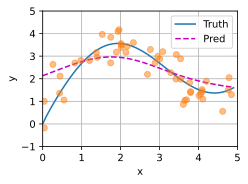

In [13]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在让我们来看看注意力的权重。这里测试输入是查询，而训练输入是关键。由于两个输入都是排序的，我们可以看到查询键对越接近，注意力集中的注意力就越高。


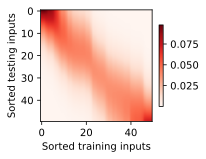

In [14]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## 参数化注意力池

非参数 Nadaraya-Watson 内核回归具有 * 一致性 * 的好处：如果有足够的数据，此模型会收敛到最佳解决方案。尽管如此，我们可以轻松地将可学习的参数集成到注意力池中。

例如，与 :eqref:`eq_nadaraya-waston-gaussian` 略有不同，在下面的查询 $x$ 和键 $x_i$ 之间的距离乘以可学习参数 $w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_i)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
:eqlabel:`eq_nadaraya-waston-gaussian-para`

在本节的其余部分中，我们将通过学习 :eqref:`eq_nadaraya-waston-gaussian-para` 中注意力集中的参数来训练此模型。

### 批量矩阵乘法
:label:`subsec_batch_dot`

为了更有效地计算小批次的注意力，我们可以利用深度学习框架提供的批量矩阵乘法实用程序。

假设第一个微型批次包含 $n$ 矩阵 $n$，形状为 $a\times b$，第二个微型批次包含 $n$ 矩阵 $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，形状为 73229363620。它们的批量矩阵乘法得出 $n$ 矩阵 $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，形状为 $a\times c$。因此，假定两个张量的形状（$n$、$a$、$b$）和（$b$，$c$）的形状，它们的批量矩阵乘法输出的形状为（$n$、$a$、$c$）。


In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景下，我们可以使用微型批次矩阵乘法来计算微型批次中值的加权平均值。


In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

### 定义模型

使用微型批量矩阵乘法，下面我们根据 :eqref:`eq_nadaraya-waston-gaussian-para` 中的参数关注池定义 Nadaraya-Watson 内核回归的参数化版本。


In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### 培训

在以下内容中，我们将训练数据集转换为键和值，以训练注意力模型。在参数化注意力池中，任何训练输入都会从所有训练示例中获取键值对，但用于预测其输出。


In [11]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))

我们使用平方损失和随机梯度下降，训练参数化注意力模型。


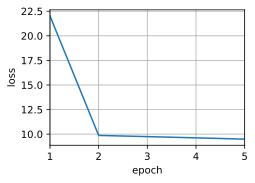

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

训练参数化注意力模型后，我们可以绘制其预测。试图使用噪点拟合训练数据集，预测线不如之前绘制的非参数对应线平滑。


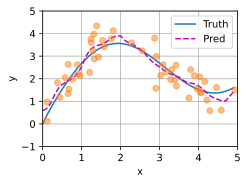

In [13]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

与非参数化注意力池相比，注意力权重较大的区域在可学习和参数化设置中变得更加锐利。


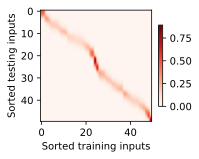

In [14]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## 摘要

* Nadaraya-Watson 内核回归是具有注意机制的机器学习示例。
* Nadaraya-Watson 内核回归的注意力集中是训练输出的加权平均值。从注意力的角度来看，根据查询的函数和与值配对的键，将注意力权重分配给值。
* 注意力池可以是非参数化的，也可以是参数化的。

## 练习

1. 增加培训示例的数量。你能更好地学习非参数 Nadaraya-Watson 内核回归吗？
1. 我们在参数化注意力池实验中学到的 $w$ 的价值是什么？为什么在可视化注意力权重时，它会使加权区域更加锐利？
1. 我们如何将超参数添加到非参数 Nadaraya-Watson 内核回归中以更好地预测？
1. 为本节的内核回归设计另一个参数化注意力池。训练这个新模型并可视化其注意力重量。


[Discussions](https://discuss.d2l.ai/t/1599)
